<a href="https://colab.research.google.com/github/9M3a1h3d9i9/DL-projects/blob/main/SegmentNet_NN_project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **بسم الله الرحمن الرحیم**

# 1. فراخوانی کتابخانه‌های مورد نیاز


In [1]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


In [2]:
!pip install -q kagglehub

# تنظیمات دستگاه (استفاده از GPU اگر موجود باشد)


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aryashah2k/breast-ultrasound-images-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'breast-ultrasound-images-dataset' dataset.
Path to dataset files: /kaggle/input/breast-ultrasound-images-dataset


# ساخت کلاس دیتاست و پردازش تصویر

حالا باید قدم دوم (آماده‌سازی داده‌ها) را انجام بدهیم. این مرحله طبق مقاله ، دو نکته‌ی ریز و مهم دارد که باید در کد رعایت کنیم:

ادغام ماسک‌ها: بعضی عکس‌ها چند تومور دارند `(مثلاً mask_1.png, mask.png)`. باید این‌ها را روی هم بندازیم تا یک ماسک واحد درست شود.


تغییر سایز: تمام عکس‌ها باید به ابعاد ۲۵۶×۲۵۶ تبدیل شوند.

Total Images Found: 780


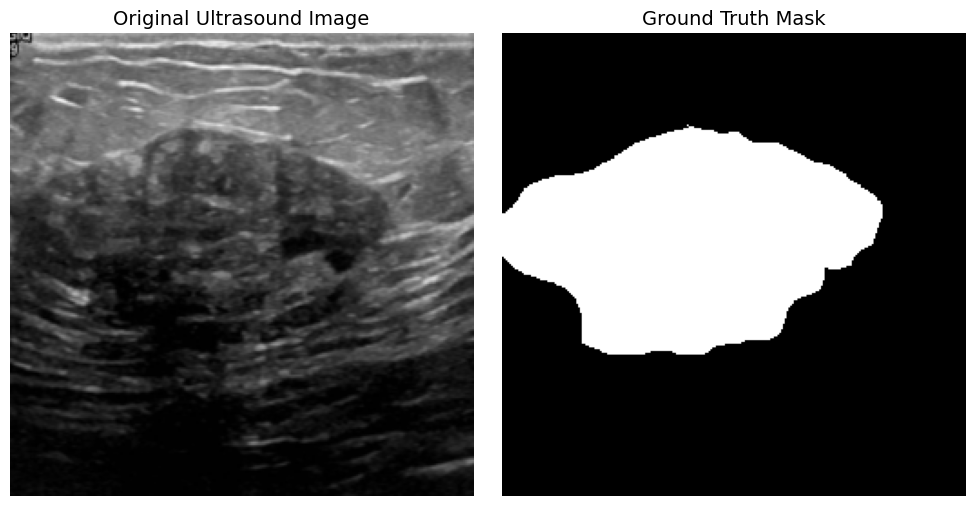

In [5]:
import torchvision.transforms.functional as TF

class BUSIDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images = []
        self.masks = []

        # دسته‌های موجود در دیتاست
        categories = ['benign', 'malignant', 'normal']

        for category in categories:
            # پیدا کردن مسیر دقیق هر دسته
            category_path = ""
            for root, dirs, files in os.walk(root_dir):
                if category in os.path.basename(root):
                    category_path = root
                    break

            if not category_path: continue

            # لیست کردن فایل‌های اصلی (غیر از ماسک‌ها)
            file_list = [f for f in os.listdir(category_path) if f.endswith('.png') and '_mask' not in f]

            for file_name in file_list:
                img_path = os.path.join(category_path, file_name)
                self.images.append(img_path)

                # ساختن لیست ماسک‌های مرتبط
                # ماسک اصلی: name_mask.png
                # ماسک‌های فرعی احتمالی: name_mask_1.png, name_mask_2.png
                base_name = file_name.replace('.png', '')
                mask_paths = []

                # اضافه کردن ماسک اصلی
                mask_name = base_name + '_mask.png'
                mask_paths.append(os.path.join(category_path, mask_name))

                # بررسی ماسک‌های اضافی (تا 4 ماسک اضافی چک می‌شود)
                for i in range(1, 5):
                    extra_mask = base_name + f'_mask_{i}.png'
                    extra_path = os.path.join(category_path, extra_mask)
                    if os.path.exists(extra_path):
                        mask_paths.append(extra_path)

                self.masks.append(mask_paths)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # 1. خواندن تصویر اصلی
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")

        # 2. خواندن و ادغام ماسک‌ها
        mask_paths = self.masks[idx]
        merged_mask_np = None

        for m_path in mask_paths:
            if os.path.exists(m_path):
                mask = Image.open(m_path).convert("L") # سیاه و سفید
                mask_np = np.array(mask)

                if merged_mask_np is None:
                    merged_mask_np = mask_np
                else:
                    # ترکیب ماسک‌ها (اگر در هر کدام تومور بود، در نهایی هم باشد)
                    merged_mask_np = np.maximum(merged_mask_np, mask_np)

        # تبدیل دوباره به تصویر
        if merged_mask_np is not None:
            mask = Image.fromarray(merged_mask_np)
        else:
            # اگر ماسکی پیدا نشد (نباید اتفاق بیفتد)، یک صفحه سیاه بساز
            mask = Image.new('L', image.size, 0)

        # 3. تغییر سایز به 256x256 (طبق مقاله)
        # استفاده از تابع TF برای سادگی و هماهنگی
        image = TF.resize(image, (256, 256))
        mask = TF.resize(mask, (256, 256), interpolation=Image.NEAREST)

        # تبدیل به تنسور (اعداد بین 0 و 1)
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)

        return image, mask

# --- اجرای کد و تست ---

# ساخت دیتاست
full_dataset = BUSIDataset(root_dir=path)
print(f"Total Images Found: {len(full_dataset)}")

# انتخاب یک نمونه که حتما تومور داشته باشد (از 500 به بعد معمولا بدخیم هستند)
# یا رندوم انتخاب می‌کنیم
idx = np.random.randint(0, len(full_dataset))
sample_img, sample_mask = full_dataset[idx]

# نمایش تصویر
plt.figure(figsize=(10, 5))

# تصویر اصلی
plt.subplot(1, 2, 1)
plt.title("Original Ultrasound Image", fontsize=14)
# جابجایی ابعاد برای نمایش صحیح (Channels, Height, Width) -> (H, W, C)
plt.imshow(sample_img.permute(1, 2, 0))
plt.axis('off')

# تصویر ماسک
plt.subplot(1, 2, 2)
plt.title("Ground Truth Mask", fontsize=14)
plt.imshow(sample_mask.permute(1, 2, 0), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

**توضیح کوتاه**

این کد تمام پوشه‌ها را می‌گردد، عکس‌ها را پیدا می‌کند و اگر عکسی چند ماسک داشت `(یعنی چند تومور داشت)`، آن‌ها را یکی می‌کند. در نهایت هم یک نمونه را نمایش می‌دهد تا مطمئن شویم داده‌ها درست خوانده شده‌اند.

اگر خروجی تعداد تصاویر حدود ۷۸۰ تا بود و عکس و ماسک را درست نشان داد، بگو تا کد مرحله بعد (تقسیم داده‌ها به ) را بدهم.

# ساخت بلوک‌های اختصاصی `SegmentNet`

## ۱.  DaM (مکانیسم آگاهی از فاصله)


این بخش وظیفه دارد ارتباط بین پیکسل‌های دور از هم را بفهمد (دید کلی).

## ۲.  LFEB (استخراج ویژگی محلی):

 این بخش وظیفه دارد لبه‌های دقیق تومور را با دقت بالا پیدا کند (دید جزئی).

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------------------------------------------------
# 1. بلوک استخراج ویژگی محلی (LFEB) - اصلاح شده و نهایی
# طبق شکل 5 و فرمول 7 و 8 مقاله
# ---------------------------------------------------------
class LFEB(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LFEB, self).__init__()

        # بخش اول: Depthwise Convolution
        # نکته حیاتی: تعداد کانال ورودی و خروجی در این مرحله برابر است (in_channels)
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.act1 = nn.ReLU(inplace=True)

        # بخش دوم: Pointwise Convolution
        # تغییر تعداد کانال اینجا اتفاق می‌افتد (مثلاً 512 به 1024)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.act2 = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        # 1. عملیات Depthwise
        out = self.depthwise(x)
        out = self.act1(out)
        out = self.bn1(out)

        # 2. اتصال باقی‌مانده (Residual Connection)
        # طبق فرمول 7 مقاله: جمع قبل از ورود به لایه Pointwise انجام می‌شود
        # در این لحظه هم 'out' و هم 'identity' دارای ابعاد یکسان (512) هستند
        out = out + identity

        # 3. عملیات Pointwise (تغییر سایز)
        # طبق فرمول 8 مقاله
        out = self.pointwise(out)
        out = self.act2(out)
        out = self.bn2(out)

        return out

# کلاس DaM بدون تغییر باقی می‌ماند، اما برای اطمینان دوباره تعریف می‌کنیم
class DaM(nn.Module):
    def __init__(self, in_channels, num_heads=4):
        super(DaM, self).__init__()
        self.num_heads = num_heads
        self.head_dim = in_channels // num_heads

        self.memory_k = nn.Parameter(torch.randn(1, num_heads, self.head_dim, self.head_dim))
        self.memory_v = nn.Parameter(torch.randn(1, num_heads, self.head_dim, self.head_dim))

        self.out_proj = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.norm = nn.LayerNorm(in_channels)

    def forward(self, x):
        B, C, H, W = x.shape
        q = x.view(B, self.num_heads, self.head_dim, H * W)
        attn = torch.einsum('bhdn,hkdm->bhnm', q, self.memory_k).softmax(dim=-1)
        out = torch.einsum('bhnm,hkdm->bhdn', attn, self.memory_v).reshape(B, C, H, W)
        out = self.out_proj(out)
        out = out.permute(0, 2, 3, 1)
        out = self.norm(out)
        out = out.permute(0, 3, 1, 2)
        return out + x

print("Fixed LFEB Block loaded successfully.")

Fixed LFEB Block loaded successfully.


**ماژول LFEB:**

 مثل ذره‌بین عمل می‌کند و جزئیات ریز بافت‌ها را می‌بیند

**ماژول DaM:**

مثل نمای هلی‌کوپتری عمل می‌کند و کل تصویر را یکجا تحلیل می‌کند

# SegmentNet Architect (Model)

این مدل یک ساختار (یو شکل ) دارد `U-Shape`




In [7]:
class ConvBlock(nn.Module):
    """
    بلوک استاندارد کانولوشن (دو بار کانولوشن پشت سر هم)
    طبق شکل 6 مقاله: Conv 3x3 -> BN -> ReLU -> Conv 3x3 -> BN -> ReLU
    """
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class SegmentNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(SegmentNet, self).__init__()

        # تعداد کانال‌ها طبق مقاله (C1=64, C2=128, C3=256, C4=512, C5=1024) [cite: 350]
        filters = [64, 128, 256, 512, 1024]

        # --- Encoder (مسیر پایین‌رو) ---
        # هر مرحله شامل: ConvBlock -> DaM -> MaxPool
        self.enc1 = ConvBlock(in_channels, filters[0])
        self.dam1 = DaM(filters[0])
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc2 = ConvBlock(filters[0], filters[1])
        self.dam2 = DaM(filters[1])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc3 = ConvBlock(filters[1], filters[2])
        self.dam3 = DaM(filters[2])
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc4 = ConvBlock(filters[2], filters[3])
        self.dam4 = DaM(filters[3])
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # --- Bottleneck (گلوگاه) ---
        # استفاده از LFEB در پایین‌ترین نقطه [cite: 295]
        self.bottleneck = LFEB(filters[3], filters[4])

        # --- Decoder (مسیر بالا‌رو) ---
        # هر مرحله شامل: Upsample -> Concat (با خروجی DaM انکودر) -> ConvBlock

        # نکته مهم: در Skip Connection هم طبق شکل 6 از DaM استفاده می‌شود [cite: 293]
        self.skip_dam4 = DaM(filters[3])
        self.up4 = nn.ConvTranspose2d(filters[4], filters[3], kernel_size=2, stride=2)
        self.dec4 = ConvBlock(filters[4], filters[3]) # ورودی دوبراور است چون Concat شده

        self.skip_dam3 = DaM(filters[2])
        self.up3 = nn.ConvTranspose2d(filters[3], filters[2], kernel_size=2, stride=2)
        self.dec3 = ConvBlock(filters[3], filters[2])

        self.skip_dam2 = DaM(filters[1])
        self.up2 = nn.ConvTranspose2d(filters[2], filters[1], kernel_size=2, stride=2)
        self.dec2 = ConvBlock(filters[2], filters[1])

        self.skip_dam1 = DaM(filters[0])
        self.up1 = nn.ConvTranspose2d(filters[1], filters[0], kernel_size=2, stride=2)
        self.dec1 = ConvBlock(filters[1], filters[0])

        # لایه خروجی نهایی (تولید ماسک دودویی)
        self.final_conv = nn.Conv2d(filters[0], out_channels, kernel_size=1)

    def forward(self, x):
        # --- Encoder ---
        e1 = self.enc1(x)
        e1_dam = self.dam1(e1) # ذخیره برای Skip Connection
        p1 = self.pool1(e1_dam)

        e2 = self.enc2(p1)
        e2_dam = self.dam2(e2)
        p2 = self.pool2(e2_dam)

        e3 = self.enc3(p2)
        e3_dam = self.dam3(e3)
        p3 = self.pool3(e3_dam)

        e4 = self.enc4(p3)
        e4_dam = self.dam4(e4)
        p4 = self.pool4(e4_dam)

        # --- Bottleneck ---
        b = self.bottleneck(p4)

        # --- Decoder ---
        # مرحله 4
        d4 = self.up4(b)
        # اعمال DaM روی Skip Connection قبل از اتصال
        skip4 = self.skip_dam4(e4_dam)
        # اگر سایزها دقیقاً یکی نبود (به خاطر رند شدن در پولینگ)، باید ریزایز کنیم
        if d4.shape != skip4.shape:
            d4 = F.interpolate(d4, size=skip4.shape[2:], mode='bilinear', align_corners=True)
        d4 = torch.cat((skip4, d4), dim=1) # اتصال
        d4 = self.dec4(d4)

        # مرحله 3
        d3 = self.up3(d4)
        skip3 = self.skip_dam3(e3_dam)
        if d3.shape != skip3.shape:
            d3 = F.interpolate(d3, size=skip3.shape[2:], mode='bilinear', align_corners=True)
        d3 = torch.cat((skip3, d3), dim=1)
        d3 = self.dec3(d3)

        # مرحله 2
        d2 = self.up2(d3)
        skip2 = self.skip_dam2(e2_dam)
        if d2.shape != skip2.shape:
            d2 = F.interpolate(d2, size=skip2.shape[2:], mode='bilinear', align_corners=True)
        d2 = torch.cat((skip2, d2), dim=1)
        d2 = self.dec2(d2)

        # مرحله 1
        d1 = self.up1(d2)
        skip1 = self.skip_dam1(e1_dam)
        if d1.shape != skip1.shape:
            d1 = F.interpolate(d1, size=skip1.shape[2:], mode='bilinear', align_corners=True)
        d1 = torch.cat((skip1, d1), dim=1)
        d1 = self.dec1(d1)

        # خروجی نهایی
        return self.final_conv(d1)

# تست مدل
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SegmentNet().to(device)
print("SegmentNet Model Created Successfully!")
print(f"Running on: {device}")

SegmentNet Model Created Successfully!
Running on: cuda


# Training Model


۱. داده‌ها را به سه دسته (آموزش، تست، اعتبارسنجی) تقسیم کنیم (طبق نسبت ۳:۱:۱ مقاله).

(Loss Function)

۲. تابع خطا  را بسازیم
(Combbine of BCE و Dice).

(Training Loop)

۳. حلقه آموزش  را بنویسیم تا مدل یاد بگیرد.

 ۴. نتایج را نمایش دهیم.

## نکته
**`(Epochs)`**

 تعداد دورهای آموزش  را برای نمایش سریع روی ۱۰ گذاشته شده.

 اگر خواستی دقت نهایی را بگیری، عدد

num_epochs

  را به ۵۰ یا ۱۰۰ تغییر بده
  
  (مقاله ۳۰۰ دور پیشنهاد داده که حدود ۲-۳ ساعت طول می‌کشد).

In [10]:
!pip install -q torchinfo
from torchinfo import summary

# فرض کنید 'model' و 'device' قبلاً تعریف شده‌اند.
# اگر مدل را هنوز به دستگاه منتقل نکرده‌اید، این خط را اضافه کنید:
# model.to(device)

# نمایش خلاصه مدل
# input_size باید متناسب با ورودی مدل باشد (Batch_size, Channels, Height, Width)
# برای تصاویر 256x256 با 3 کانال و یک بچ سایز 1، input_size به این شکل خواهد بود:
summary(model, input_size=(1, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
SegmentNet                               [1, 1, 256, 256]          --
├─ConvBlock: 1-1                         [1, 64, 256, 256]         --
│    └─Sequential: 2-1                   [1, 64, 256, 256]         --
│    │    └─Conv2d: 3-1                  [1, 64, 256, 256]         1,792
│    │    └─BatchNorm2d: 3-2             [1, 64, 256, 256]         128
│    │    └─ReLU: 3-3                    [1, 64, 256, 256]         --
│    │    └─Conv2d: 3-4                  [1, 64, 256, 256]         36,928
│    │    └─BatchNorm2d: 3-5             [1, 64, 256, 256]         128
│    │    └─ReLU: 3-6                    [1, 64, 256, 256]         --
├─DaM: 1-2                               [1, 64, 256, 256]         2,048
│    └─Conv2d: 2-2                       [1, 64, 256, 256]         4,160
│    └─LayerNorm: 2-3                    [1, 256, 256, 64]         128
├─MaxPool2d: 1-3                         [1, 64, 128, 128]         --

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. تنظیمات و هایپرپارامترها (طبق جدول 1 مقاله)
# ---------------------------------------------------------
BATCH_SIZE = 8          # سایز دسته‌ها
LEARNING_RATE = 0.0001  # نرخ یادگیری
EPOCHS = 10             # تعداد دورهای آموزش (برای تست 10، برای نتیجه نهایی 300)

# ---------------------------------------------------------
# 2. تقسیم داده‌ها (Train/Val/Test)
# نسبت تقسیم: 60% آموزش، 20% اعتبارسنجی، 20% تست
# ---------------------------------------------------------
total_size = len(full_dataset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42) # برای نتایج قابل تکرار
)

# ساخت DataLoaderها (برای بارگذاری دسته‌ای داده‌ها در GPU)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False) # بچ سایز 1 برای نمایش راحت‌تر

print(f"Data Split: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")

# ---------------------------------------------------------
# 3. تعریف تابع خطا (Loss Function)
# طبق فرمول 17 مقاله: Loss = 0.5 * BCE + Dice
# ---------------------------------------------------------
class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # مسطح کردن تنسورها (Flatten)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)

        return 1 - dice # چون می‌خواهیم خطا کم شود (دایس زیاد شود)

# ترکیب BCE و Dice
def criterion(pred, target):
    bce = nn.BCEWithLogitsLoss()(pred, target) # خودش سیگمویید دارد
    pred_sig = torch.sigmoid(pred) # برای دایس باید احتمال بین 0 و 1 باشد
    dice = DiceLoss()(pred_sig, target)
    return 0.5 * bce + dice

# ---------------------------------------------------------
# 4. حلقه آموزش (Training Loop)
# ---------------------------------------------------------
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # بهینه‌ساز Adam

print("Starting Training...")
train_losses = []

for epoch in range(EPOCHS):
    model.train() # حالت آموزش
    running_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # 1. صفر کردن گرادیان‌ها
        optimizer.zero_grad()

        # 2. پیش‌بینی مدل
        outputs = model(images)

        # 3. محاسبه خطا
        loss = criterion(outputs, masks)

        # 4. آپدیت وزن‌ها (Backpropagation)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}")

print("Training Finished!")


Data Split: Train=468, Val=156, Test=156
Starting Training...
Epoch [1/10], Loss: 1.0877
Epoch [2/10], Loss: 0.9651
Epoch [3/10], Loss: 0.8859
Epoch [4/10], Loss: 0.8306
Epoch [5/10], Loss: 0.8044
Epoch [6/10], Loss: 0.7712
Epoch [7/10], Loss: 0.7197
Epoch [8/10], Loss: 0.7230
Epoch [9/10], Loss: 0.6898
Epoch [10/10], Loss: 0.6754
Training Finished!


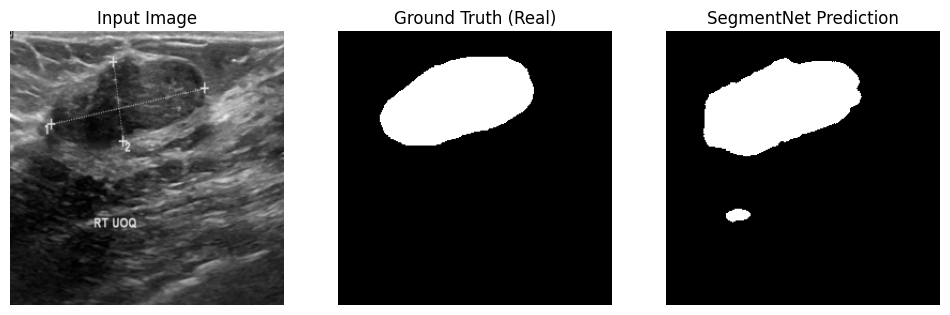

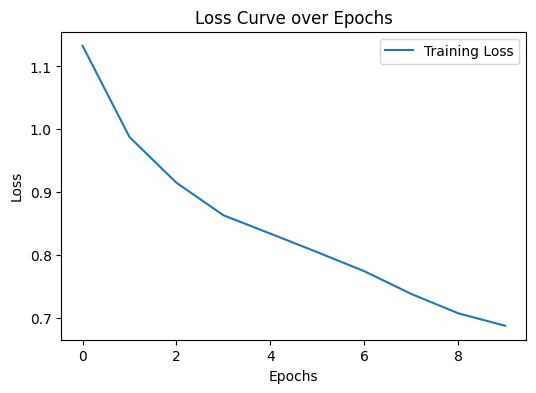

In [ ]:
# ---------------------------------------------------------
# 5. نمایش نتایج (Visualization)
# مقایسه خروجی مدل با واقعیت روی داده‌های تست
# ---------------------------------------------------------
model.eval() # حالت ارزیابی (غیرفعال کردن دراپ‌اوت و ...)
with torch.no_grad():
    # گرفتن یک نمونه از تست
    try:
        img, mask = next(iter(test_loader))
        img = img.to(device)

        # پیش‌بینی
        output = model(img)
        pred_mask = torch.sigmoid(output) # تبدیل به احتمال
        pred_mask = (pred_mask > 0.5).float() # باینری کردن (سفید یا سیاه)

        # نمایش
        plt.figure(figsize=(12, 4))

        # تصویر اصلی
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(img.cpu().squeeze().permute(1, 2, 0))
        plt.axis('off')

        # ماسک واقعی (Ground Truth)
        plt.subplot(1, 3, 2)
        plt.title("Ground Truth (Real)")
        plt.imshow(mask.cpu().squeeze(), cmap='gray')
        plt.axis('off')

        # ماسک پیش‌بینی شده (SegmentNet)
        plt.subplot(1, 3, 3)
        plt.title("SegmentNet Prediction")
        plt.imshow(pred_mask.cpu().squeeze(), cmap='gray')
        plt.axis('off')

        plt.show()
    except Exception as e:
        print(f"Error in visualization: {e}")

# رسم نمودار کاهش خطا
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Training Loss')
plt.title("Loss Curve over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluation Metrics

In [ ]:
import numpy as np

def calculate_metrics(model, loader, device):
    """
    محاسبه دقیق معیارهای ارزیابی طبق فرمول‌های مقاله SegmentNet
    شامل: IoU, Accuracy, Sensitivity, Specificity, F1-Score, Dice
    """
    model.eval()

    # متغیرها برای جمع‌بندی مقادیر کل دیتاست
    total_iou = 0.0
    total_acc = 0.0
    total_sens = 0.0
    total_spec = 0.0
    total_f1 = 0.0
    total_dice = 0.0
    num_batches = 0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            # پیش‌بینی مدل
            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float() # باینری کردن (0 یا 1)

            # تبدیل به بردار خطی برای محاسبه راحت‌تر
            preds = preds.view(-1)
            targets = masks.view(-1)

            # محاسبه پارامترهای پایه (TP, TN, FP, FN)
            TP = (preds * targets).sum().item()
            FP = ((preds == 1) & (targets == 0)).sum().item()
            FN = ((preds == 0) & (targets == 1)).sum().item()
            TN = ((preds == 0) & (targets == 0)).sum().item()

            # جلوگیری از تقسیم بر صفر (Smooth)
            smooth = 1e-6

            # 1. Accuracy (دقت کلی) - فرمول 11 مقاله
            acc = (TP + TN) / (TP + TN + FP + FN + smooth)

            # 2. Specificity (نرخ تشخیص درست بافت سالم) - فرمول 12 مقاله
            spec = TN / (TN + FP + smooth)

            # 3. Sensitivity / Recall (نرخ تشخیص درست تومور) - فرمول 13 مقاله
            sens = TP / (TP + FN + smooth)

            # 4. F1-Score - فرمول 14 مقاله
            f1 = (2 * TP) / (2 * TP + FP + FN + smooth)

            # 5. IoU (Jaccard Index) - فرمول 15 مقاله
            # IoU = TP / (TP + FP + FN)
            iou = TP / (TP + FP + FN + smooth)

            # 6. Dice Score - فرمول 16 مقاله
            dice = (2 * TP) / ((TP + FP) + (TP + FN) + smooth)

            # جمع‌بندی
            total_iou += iou
            total_acc += acc
            total_sens += sens
            total_spec += spec
            total_f1 += f1
            total_dice += dice
            num_batches += 1

    # محاسبه میانگین
    print("-" * 30)
    print("Final Evaluation Results on Test Set:")
    print("-" * 30)
    print(f"Mean IoU:         {total_iou/num_batches:.4f}  (Expected: ~80-90%)")
    print(f"Mean Accuracy:    {total_acc/num_batches:.4f}")
    print(f"Mean Sensitivity: {total_sens/num_batches:.4f}")
    print(f"Mean Specificity: {total_spec/num_batches:.4f}")
    print(f"Mean F1-Score:    {total_f1/num_batches:.4f}")
    print(f"Mean Dice Score:  {total_dice/num_batches:.4f}")
    print("-" * 30)

# اجرای تابع ارزیابی
calculate_metrics(model, test_loader, device)

------------------------------
Final Evaluation Results on Test Set:
------------------------------
Mean IoU:         0.3359  (Expected: ~80-90%)
Mean Accuracy:    0.9420
Mean Sensitivity: 0.4987
Mean Specificity: 0.9685
Mean F1-Score:    0.4240
Mean Dice Score:  0.4240
------------------------------
